# Plan og arbeidsflyt i GiHub



1. åpne terminalen i mappen lokalt på deres maskin.
2. kjør kommandoene:

git fetch origin $$$$
git pull origin master$$$$

3. Da vil master-branchen oppdateres lokalt hos dere. Nå skal dere lage en branch hvor den nye koden skal skrives. Velg et navn til branchen (gjerne noe deksriptivt), og kjør kommandoen.

$$$$
git checkout -b NAVN $$$$

3. hvor NAVN er navnet dere valgte (NAVN må være uten mellomrom). Dere må også passe på å ikke lage branch-navn som krasjer (altså, hvis både trond og ola lager branchen 'feature', så vil alt bli ødelagt :) )



4. Nå kan dere gjøre endringer fritt. Pass dog på at dere skriver i den SAMME cellen i jupyter. Dette er viktig. Vi tildeler celler sammen, så ikke start å jobbe før vi har blitt enig om celler. 

5. Når dere er ferdig å jobbe, kjør kommandoene:

$$$$
git add .$$$$
git commit -m "MELDING"$$$$

5. og bytt ut MELDING med en myyye mer deskriptiv mld. Dette er også viktig, da denne meldingen kan brukes til å finne tilbake til gammel kode

6. dytt koden til github ved å kjøre kommandoen: 

$$$$
git push origin NAVN $$$$

6. hvor NAVN igjen er navnet på branchen

7. send mld til oss andre hvis dere har pushet en branch til github. Da må vi nemlig gå inn på github og gjennomføre en "Pull-request".

# Prosjekt 1 - bio

## Innhold
* [Introduksjon](#intro)
* [...](#2.)
* [Oppgave 2](#o2)
* [...](#4.)
* [Konklusjon](#konk)

## Introduksjon <a class="anchor" id="intro"></a>

Introduksjon kommer her

In [1]:
## Libraries
from numba import jit
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import warnings

# Remove annoying deprecation warnings
warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)

#Hvordan bruke jit for å speede opp koden: basically legg til 
#@jit(nopython=True)
#def some_func():
#    return
#over hver eneste funksjon. Men vent med å gjøre det til vi har testet ferdig koden (har noe med feilmeldingene å gjøre)


import numpy as np

import matplotlib.pyplot as plt
import matplotlib.colors as c

0.445591093521832


1a

In [33]:
##1a

def generate_grid_of_monomers(N, M):
    """
        input: int N, int M: N is the grid-dimension. M is the number of positive and negative monomers
        output: N x N grid of i2-integers. 2M of which is either positive ore negative, the rest 0
    """
    grid = np.zeros((N, N), dtype=np.dtype('i2'))
    
    num = M
    while (num > 0):
        i = np.random.randint(0, N)    #choose random coordinates to place monomer
        j = np.random.randint(0, N)
        if grid[i][j] == 0:            #place monomer if there isn't one there already
            grid[i][j] = -num
            num -= 1                   #decrement inside if, ensuring M monomers int total are placed
            
    num = M
    while (num > 0):
        i = np.random.randint(0, N)
        j = np.random.randint(0, N)
        if grid[i][j] == 0:
            grid[i][j] = num
            num -= 1
    
    return grid


1b

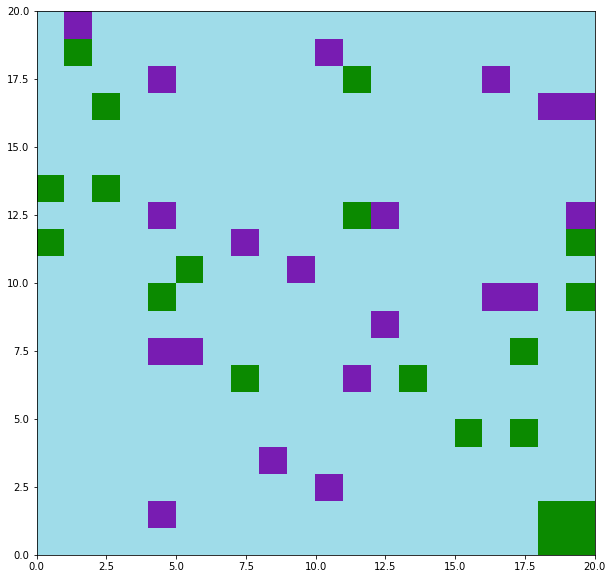

In [61]:
##1b

def visualize_grid(grid):
    """
        input: grid, 2d grid of signed integers
        function: visualizing the signed grid, different color for positive, negative and zero
        return: none
    """
    #defining colors for map
    purple = np.array([120, 28, 178])/255
    blue = np.array([159, 220, 233])/255
    green = np.array([11, 138, 0])/255
    cMap = c.ListedColormap([purple, blue, green])
    
    # Make grid have only -1, 0 and 1. [::-1,] flips the rows
    sign_grid = np.sign(grid[::-1,])
    
    # Plotting as a colormesh
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    ax.pcolormesh(sign_grid, cmap = cMap)

visualize_grid(generate_grid_of_monomers(20, 20))

1c

In [74]:
##1c
def nearest_neighbors(i, j, N):
    """
        input: int i, int j, int N. (i, j) is a coordinate in a grid, N is the size of the grid (N x N)
        output: list of the four neighboring points of (i, j). Right side connected to left and top to bottom
    """
    top = [i, (j-1+N)%N]
    right = [(i+1)%N, j]
    bottom = [i, (j +1)%N]
    left = [(i-1 + N)%N, j]
    return [top, right, bottom, left]

def test_nearest_neighbors():
    neighbors = {}
    #some random values
    neighbors[(10, 12, 20)] = [[10, 11], [11, 12], [10, 13], [ 9, 12]]
    neighbors[(0, 12, 20)] = [[ 0, 11], [ 1, 12], [ 0, 13], [19, 12]]
    neighbors[(0, 12, 15)] = [[ 0, 11], [ 1, 12], [ 0, 13], [14, 12]]
    neighbors[(38, 38, 39)] = [[ 38, 37], [ 0, 38], [38, 0], [37, 38]]
    
    correct = 0
    for key, val in neighbors.items():
        i, j, N = key
        if nearest_neighbors(i, j, N) ==  val:
            correct += 1
    print(f'the number of correct: {correct} of {len(neighbors)}')
    
test_nearest_neighbors()

the number of correct: 4 of 4


1d

In [5]:
##1d

1e

In [6]:
##1e

1f

In [7]:
##1f

1g

In [8]:
##1g

1h

In [9]:
#1h

# Oppgave 2  <a class="anchor" id="o2"></a>

2a

In [10]:
#2a

2b

In [11]:
#2b

2c

In [12]:
#2c

2d

In [13]:
#2d

2e

In [14]:
#2e

2f

In [15]:
#2f

2g

In [16]:
#2g

2h

In [17]:
#2h

# Konklusjon <a class="anchor" id="konk"></a>